## SARIMAX model

In [2]:
import statsmodels.api as sm

macro_econ_data = sm.datasets.macrodata.load_pandas().data
macro_econ_data

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
199,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
200,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
201,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19


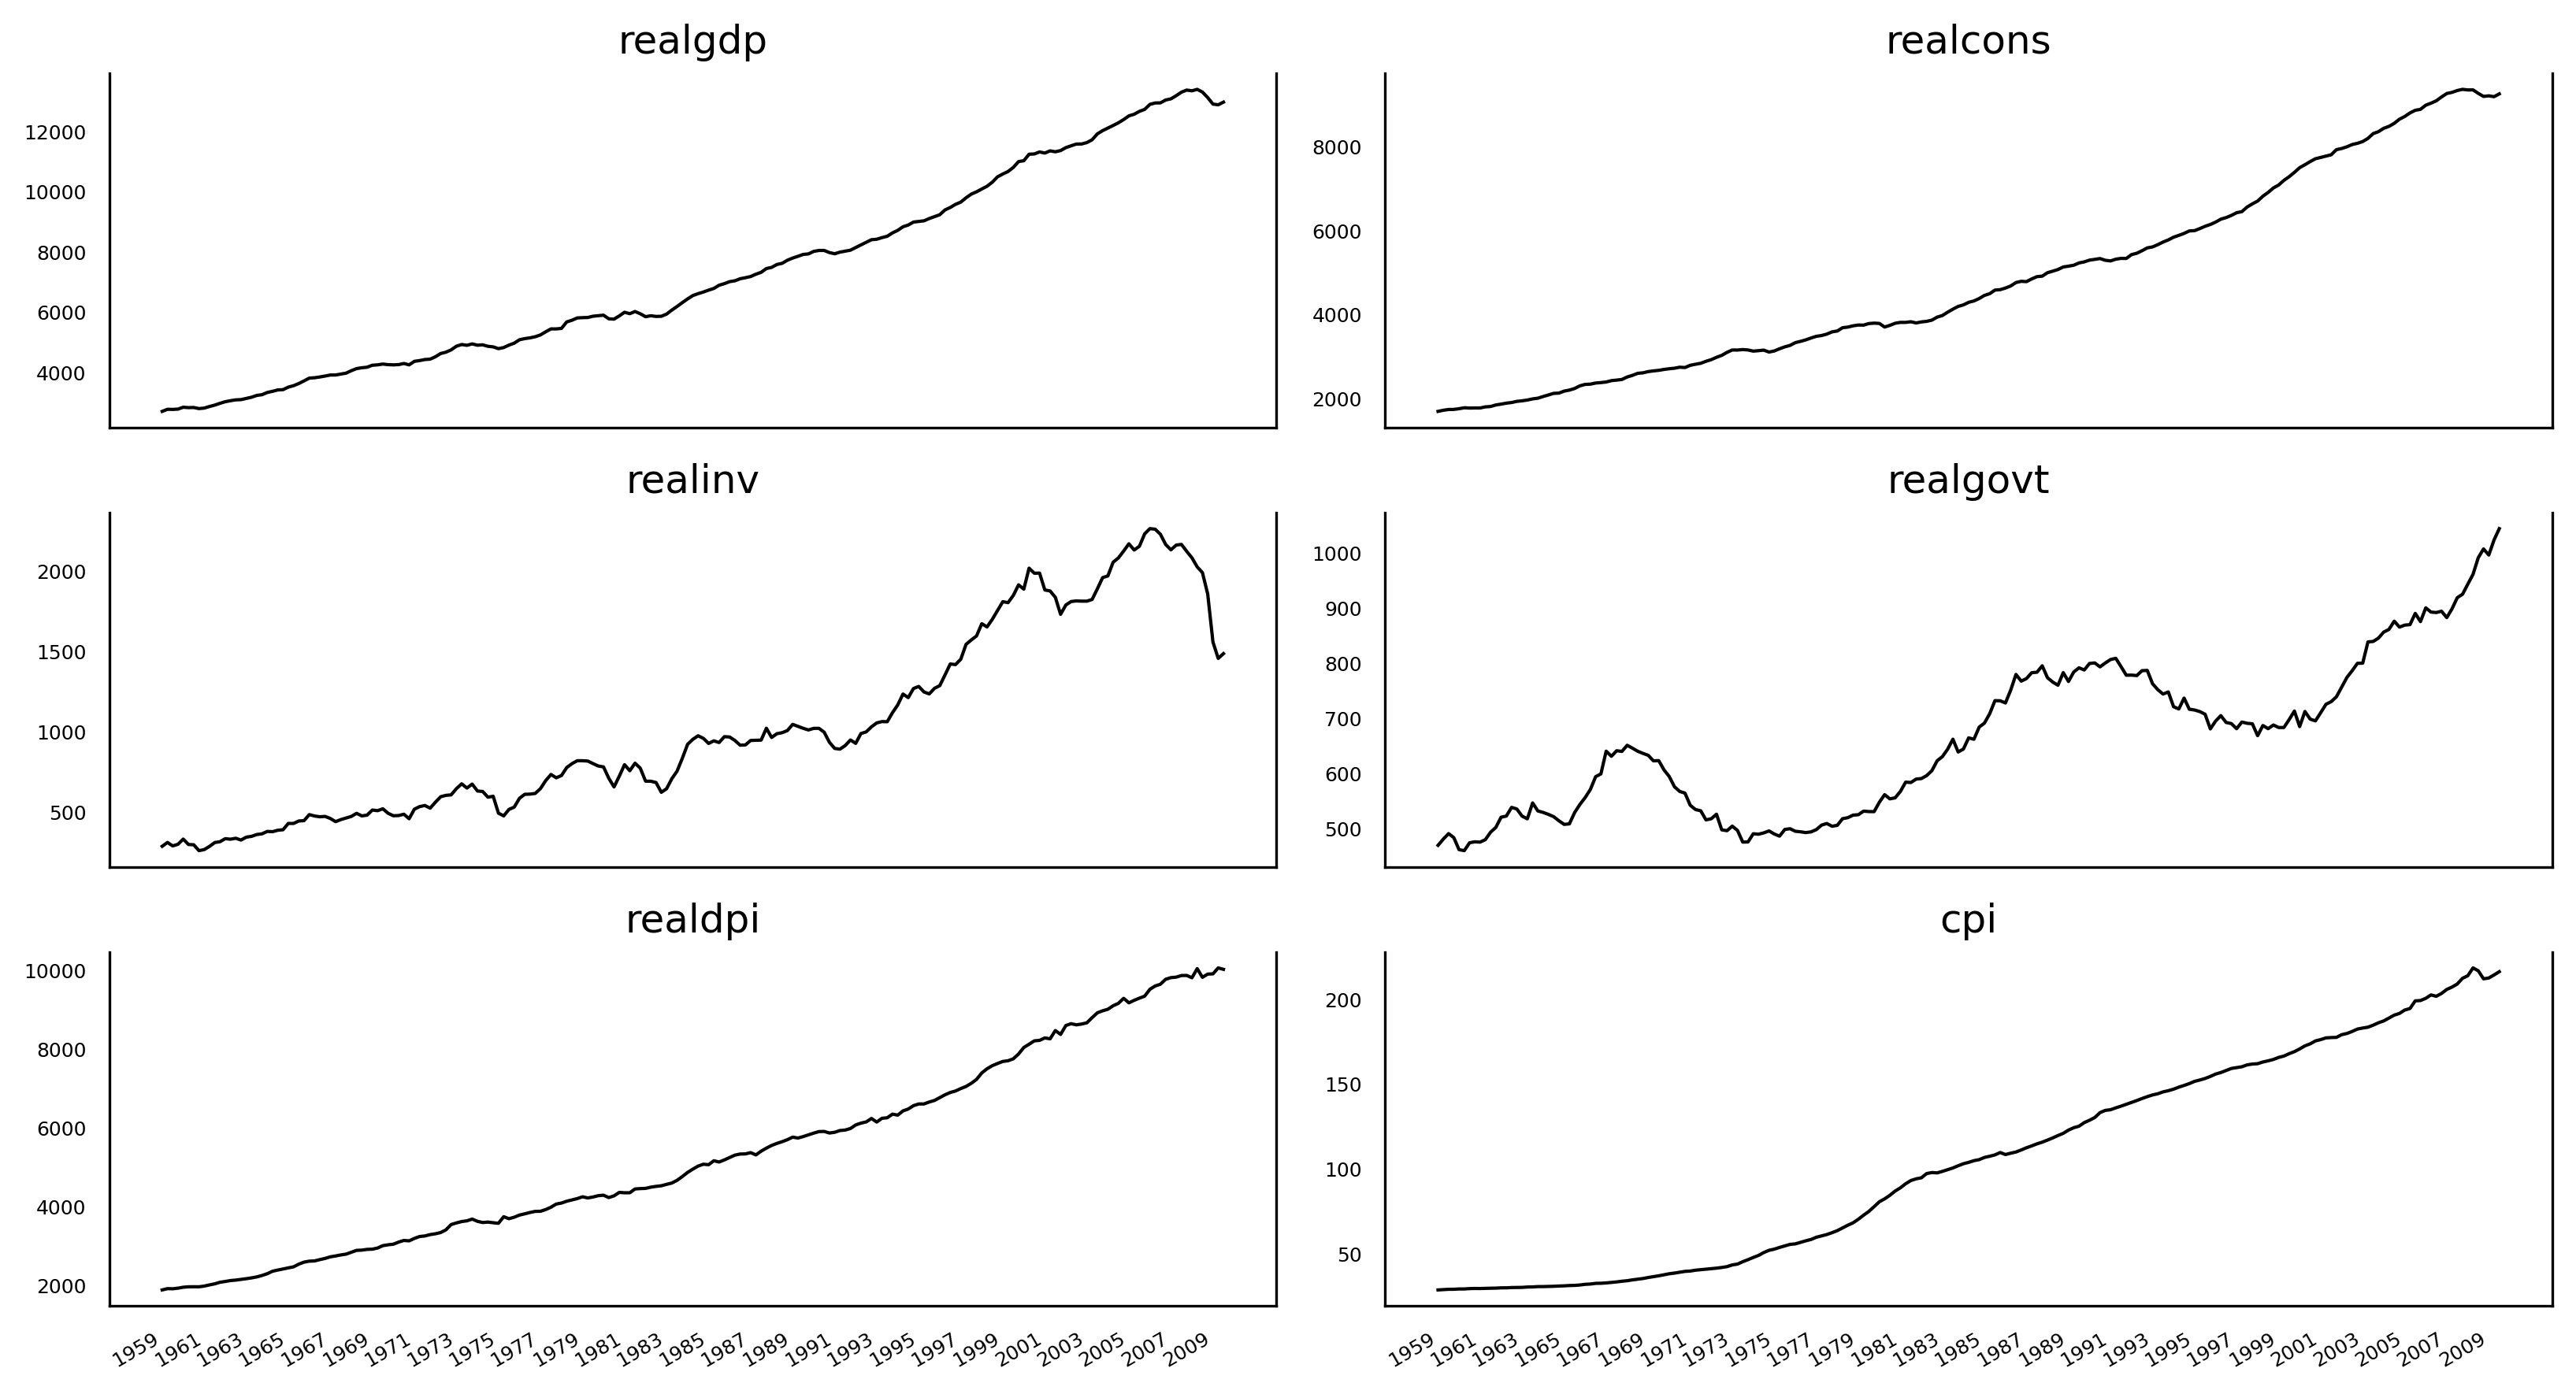

In [3]:
import matplotlib.pyplot as plt
import numpy as np


fig, axes = plt.subplots(nrows=3, ncols=2, dpi=300, figsize=(11, 6))

for i, ax in enumerate(axes.flatten()[:6]):
    data = macro_econ_data[macro_econ_data.columns[i + 2]]
    ax.plot(data, color="black", linewidth=1)
    ax.set_title(macro_econ_data.columns[i + 2])
    ax.xaxis.set_ticks_position("none")
    ax.yaxis.set_ticks_position("none")
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.setp(axes, xticks=np.arange(0, 208, 8), xticklabels=np.arange(1959, 2010, 2))
fig.autofmt_xdate()
plt.tight_layout()

In [4]:
from statsmodels.tsa.stattools import adfuller

target = macro_econ_data["realgdp"]
exog = macro_econ_data[["realcons", "realinv", "realgovt", "realdpi", "cpi"]]

ad_fuller_test = adfuller(target)

print(f"ADF stats: {ad_fuller_test[0]}")
print(f"p-value: {ad_fuller_test[1]}")

ADF stats: 1.7504627967647144
p-value: 0.9982455372335032


In [5]:
target_diff = np.diff(target, n=1)

ad_fuller_test = adfuller(target_diff)

print(f"ADF stats: {ad_fuller_test[0]}")
print(f"p-value: {ad_fuller_test[1]}")

ADF stats: -6.305695561658106
p-value: 3.327882187668224e-08


In [6]:
from typing import Union
from tqdm.notebook import tqdm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd


def optimize_SARIMAX(endog: Union[pd.Series, list], exog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:

    results = []

    for order in tqdm(order_list):

        try:
            model = SARIMAX(
                endog=endog,
                exog=exog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ["(p, q, P, Q)", "AIC"]

    result_df = result_df.sort_values(by="AIC", ascending=True).reset_index(drop=True)

    return result_df

In [7]:
from itertools import product

p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 0
Q = range(0, 4, 1)
s = 4

parameters_list = list(product(p, q, P, Q))

In [8]:
target_train = target[:200]
exog_train = exog[:200]

result_df = optimize_SARIMAX(target_train, exog_train, parameters_list, d, D, s)
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

/home/alexa/miniconda3/envs/timeseriesML/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alexa/miniconda3/envs/timeseriesML/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alexa/miniconda3/envs/timeseriesML/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alexa/miniconda3/envs/timeseriesML/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

,"(p, q, P, Q)",AIC
0,"(3, 3, 0, 0)",1742.820649
1,"(3, 3, 1, 0)",1744.964869
2,"(3, 3, 0, 1)",1744.999780
3,"(2, 2, 0, 0)",1745.472424
4,"(2, 2, 0, 1)",1745.823608
...,...,...
251,"(0, 2, 0, 0)",1761.579044
252,"(0, 3, 0, 0)",1762.317095
253,"(0, 0, 0, 0)",1764.754980
254,"(1, 0, 0, 0)",1765.379412


In [9]:
best_model = SARIMAX(target_train, exog_train, order=(3, 1, 3), seasonal_order=(0, 0, 0, 4), simple_differencing=False)
best_model_fit = best_model.fit(disp=False)

print(best_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                realgdp   No. Observations:                  200
Model:               SARIMAX(3, 1, 3)   Log Likelihood                -859.410
Date:                Sun, 05 May 2024   AIC                           1742.821
Time:                        17:06:16   BIC                           1782.340
Sample:                             0   HQIC                          1758.815
                                - 200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
realcons       0.9689      0.045     21.597      0.000       0.881       1.057
realinv        1.0136      0.033     30.812      0.000       0.949       1.078
realgovt       0.7286      0.127      5.741      0.0

/home/alexa/miniconda3/envs/timeseriesML/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


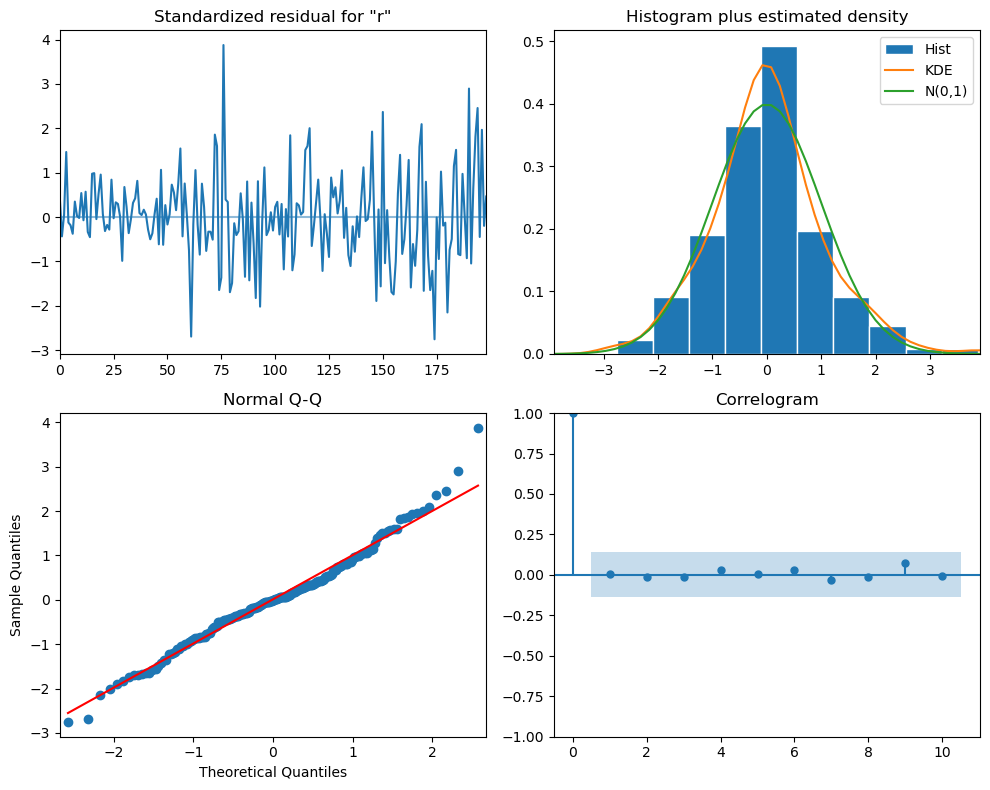

In [10]:
best_model_fit.plot_diagnostics(figsize=(10, 8))
plt.tight_layout()

In [11]:
from statsmodels.stats.diagnostic import acorr_ljungbox

residuals = best_model_fit.resid

ljung_df = acorr_ljungbox(residuals, np.arange(1, 11, 1))

ljung_df

,lb_stat,lb_pvalue
1,0.088994,0.765460
2,0.206986,0.901682
3,0.210311,0.975908
4,1.221448,0.874555
5,1.222817,0.942670
6,1.245910,0.974556
7,1.442700,0.984227
8,1.453231,0.993458
9,1.825511,0.993936
10,1.831128,0.997478


In [12]:
def rolling_forecast(endog: Union[pd.Series, list], exog: Union[pd.Series, list], train_len: int, horizon: int, window: int, method: str) -> list:

    total_len = train_len + horizon

    if method == "last":
        pred_last_value = []

        for i in range(train_len, total_len, window):
            last_value = endog[:i].iloc[-1]
            pred_last_value.extend(last_value for _ in range(window))
        
        return pred_last_value
    
    elif method == "SARIMAX":

        pred_SARIMAX = []

        for i in range(train_len, total_len, window):

            model = SARIMAX(endog=endog[:i], exog=exog[:i], order=(3, 1, 3), seasonal_order=(0, 0, 0, 4), simple_differencing=False)
            res = model.fit(disp=False)
            predictions = res.get_prediction(exog=exog)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMAX.extend(oos_pred)
        
        return pred_SARIMAX

In [13]:
target_train = target[:196]
target_test = target[196:]

pred_df = pd.DataFrame({"actual": target_test})

TRAIN_LEN = len(target_train)
HORIZON = len(target_test)
WINDOW = 1

pred_last_val = rolling_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, "last")
pred_SARIMAX = rolling_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, "SARIMAX")

pred_df["pred_last_val"] = pred_last_val
pred_df["pred_SARIMAX"] = pred_SARIMAX

pred_df

/home/alexa/miniconda3/envs/timeseriesML/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alexa/miniconda3/envs/timeseriesML/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alexa/miniconda3/envs/timeseriesML/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alexa/miniconda3/envs/timeseriesML/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

,actual,pred_last_val,pred_SARIMAX
196,13366.865,13391.249,13344.062710
197,13415.266,13366.865,13373.511220
198,13324.600,13415.266,13378.826245
199,13141.920,13324.600,13327.768263
200,12925.410,13141.920,13133.492237
201,12901.504,12925.410,12887.101810
202,12990.341,12901.504,12873.794823


In [14]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

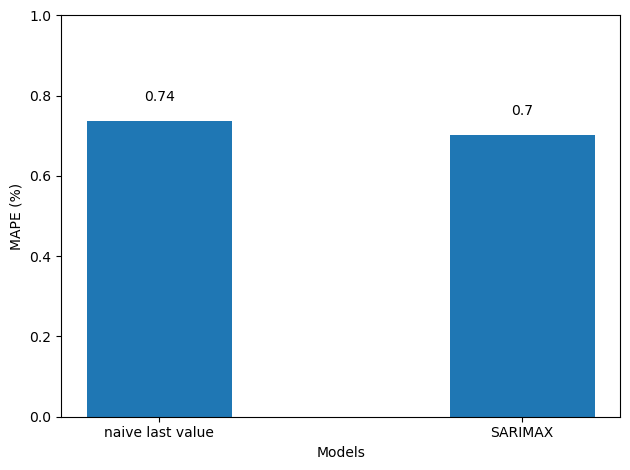

In [16]:
mape_last = mape(pred_df.actual, pred_df.pred_last_val)
mape_SARIMAX = mape(pred_df.actual, pred_df.pred_SARIMAX)

fig, ax = plt.subplots()

x = ["naive last value", "SARIMAX"]
y = [mape_last, mape_SARIMAX]

ax.bar(x, y, width=0.4)
ax.set_xlabel("Models")
ax.set_ylabel("MAPE (%)")
ax.set_ylim(0, 1)

for idx, val in enumerate(y):
    plt.text(x=idx, y=val + 0.05, s=str(round(val, 2)), ha="center")

plt.tight_layout()